In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import re
from tqdm import tqdm, trange

#sns.set_theme()

def load_data_files(path, name=None):
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        data = []
        for file in os.listdir(path):
            data.append(pd.read_csv(os.path.join(path, file), index_col=0))
        data = pd.concat(data).reset_index(drop=True)
    if name is not None:
        data["Name"] = name
    return data

def set_fixed_steps(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in tqdm((range(n_runs))):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print("hin?")
                continue
                
            shuffled_ids = random.sample(ids, len(ids))
            keep_id = shuffled_ids[0]
            drop_ids += shuffled_ids[1:]
            
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in trange(n_runs):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range + 1000)].index)
            
            if len(ids) == 0:
                #print(rows, s_i, "hin?")
                continue
            
            keep_id = ids[0]
            drop_ids += ids[1:]
            # For all numerical columns but the 'Step'
            for c in data.select_dtypes(include=np.number).columns:
                if c == "Step":
                    continue
                data.at[keep_id, c] = data.loc[ids][c].mean()
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg_index(data, n_index=10, diplay_prog=True):
    drop_ids = []
    range_fn = trange if diplay_prog else range
    for i in range_fn(0, len(data), n_index):
        ids = list(range(i, i + n_index))
        keep_id = ids[-1]
        drop_ids += ids[:-1]
        # For all numerical columns but the 'Step'
        for c in data.select_dtypes(include=np.number).columns:
            if c == "Step":
                continue
            data.at[keep_id, c] = data.loc[ids][c].mean()
    return data.drop(drop_ids)

def plot_runs(runs, x="Step", y="Episode return", estim="mean", err="sd", 
               ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
               names=None, colors=None, loc='best', size=(15, 6)):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    if ylim is not None:
        ax.set(ylim=ylim)
    #for r_i in range(len(runs)):
    #    sns.lineplot(data=runs[r_i], 
    #                 x=x, y=y, hue="Name", ax=ax, estimator=estim, errorbar=err, palette=colors)
    sns.lineplot(data=runs, x=x, y=y, hue="Name", 
                 ax=ax, estimator=estim, errorbar=err, 
                 palette=colors, legend="brief")
    #if names is not None:
    #    ax.legend(names, loc=loc, frameon=False)
    #else:
    ax.legend(loc=loc, frameon=False)
        
def box_plot_runs(runs, x="Step", y="Mean return", 
             ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
             legend=True, names=None, loc='best', size=(15, 6), 
             only_one_step=None, swarm=False, swarm_size=3, colors=None):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ylim is not None:
        ax.set(ylim=ylim, xlabel=ax_xlabel, ylabel=ax_ylabel)
    if only_one_step is not None:
        runs = runs.loc[runs["Step"] == only_one_step]
        x = "Name"
    if swarm:
        sns.swarmplot(x=x, y=y, hue="Name", data=runs, ax=ax, size=swarm_size, palette=colors)
        plt.setp(ax.get_xticklabels(), rotation=30)#, horizontalalignment="right")
    else:
        sns.boxplot(x=x, y=y, hue="Name", data=runs, ax=ax, palette=colors)
    if legend:
        if names is not None:
            ax.legend(names, loc=loc)
        else:
            ax.legend(loc=loc)
    else:
        ax.get_legend().remove()
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    return ax
        
def load_plot_runs(path, y="Episode extrinsic return"):
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            print(file)
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            run = mov_avg(run, step_range=10000, n_runs=1)
            fig1, ax1 = plt.subplots(figsize=(15, 6))
            ax1.plot(run[y])
            plt.show()

## Case study: relative overgeneralization

#### 4030

#### ALL (final graph)

All three levels together

In [14]:
qmix_30 = load_data_files(
    "../models/rel_overgen/qmix_4030/train_data/",
    name="QMIX")
qmix_loc_30 = load_data_files(
    "../models/rel_overgen/qmix_lim_4030/train_data/",
    name="QMIX+LIM")
qmix_joint_30 = load_data_files(
    "../models/rel_overgen/qmix_jim_4030/train_data/",
    name="QMIX+JIM")
mappo_30 = load_data_files(
    "../models/rel_overgen/mappo_noshare_30/train_data/",
    name="MAPPO")
mappo_LIM_30 = load_data_files(
    "../models/rel_overgen/mappo_LIM_30/train_data/",
    name="MAPPO+LIM")
mappo_JIM_30 = load_data_files(
    "../models/rel_overgen/mappo_JIM_30/train_data/",
    name="MAPPO+JIM")
ro30 = [
    mov_avg(qmix_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_30, max_steps=5000000, step_range=100000, n_runs=15),
    mov_avg(mappo_LIM_30, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_JIM_30, max_steps=5000000, step_range=100000, n_runs=15)]
    
qmix_40 = load_data_files(
    "../models/rel_overgen/qmix_4040/train_data/",
    name="QMIX")
qmix_loc_40 = load_data_files(
    "../models/rel_overgen/qmix_lim_4040/train_data/",
    name="QMIX+LIM")
qmix_joint_40 = load_data_files(
    "../models/rel_overgen/qmix_jim_4040/train_data/",
    name="QMIX+JIM")
mappo_40 = load_data_files(
    "../models/rel_overgen/mappo_noshare_50/train_data/",
    name="MAPPO")
mappo_LIM_40 = load_data_files(
    "../models/rel_overgen/mappo_LIM_40/train_data/",
    name="MAPPO+LIM")
mappo_JIM_40 = load_data_files(
    "../models/rel_overgen/mappo_JIM_40/train_data/",
    name="MAPPO+JIM")
ro40 = [
    mov_avg(qmix_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_LIM_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_JIM_40, max_steps=5000000, step_range=100000, n_runs=15)]
    
qmix_50 = load_data_files(
    "../models/rel_overgen/qmix_4050/train_data/",
    name="QMIX")
qmix_loc_50 = load_data_files(
    "../models/rel_overgen/qmix_lim_4050/train_data/",
    name="QMIX+LIM")
qmix_joint_50 = load_data_files(
    "../models/rel_overgen/qmix_jim_4050/train_data/",
    name="QMIX+JIM")
mappo_50 = load_data_files(
    "../models/rel_overgen/mappo_noshare_50/train_data/",
    name="MAPPO")
mappo_LIM_50 = load_data_files(
    "../models/rel_overgen/mappo_LIM_50/train_data/",
    name="MAPPO+LIM")
mappo_JIM_50 = load_data_files(
    "../models/rel_overgen/mappo_JIM_50/train_data/",
    name="MAPPO+JIM")
ro50 = [
    mov_avg(qmix_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_loc_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(qmix_joint_50, max_steps=5000000, step_range=100000, n_runs=15),
    mov_avg(mappo_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_LIM_50, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_JIM_50, max_steps=5000000, step_range=100000, n_runs=15)]

100%|███████████████████████████████████████████| 15/15 [00:20<00:00,  1.38s/it]


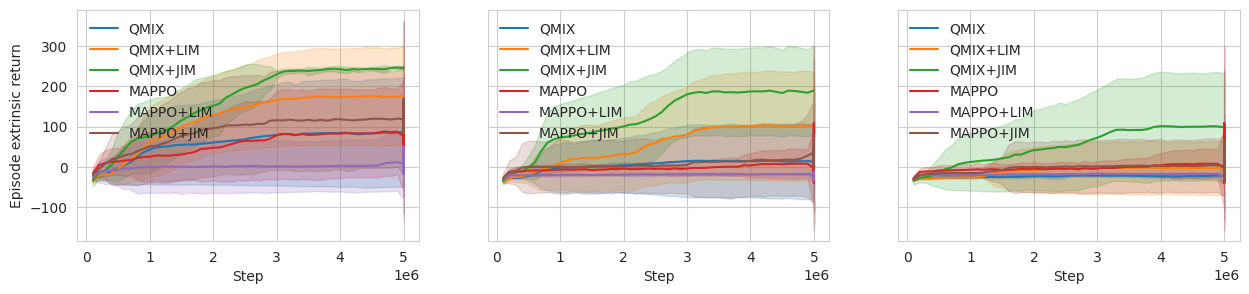

In [15]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
plot_runs(ro30, ax=ax1, y="Episode extrinsic return")
plot_runs(ro40, ax=ax2, y="Episode extrinsic return")
plot_runs(ro50, ax=ax3, y="Episode extrinsic return")

100%|███████████████████████████████████████████| 15/15 [00:19<00:00,  1.32s/it]


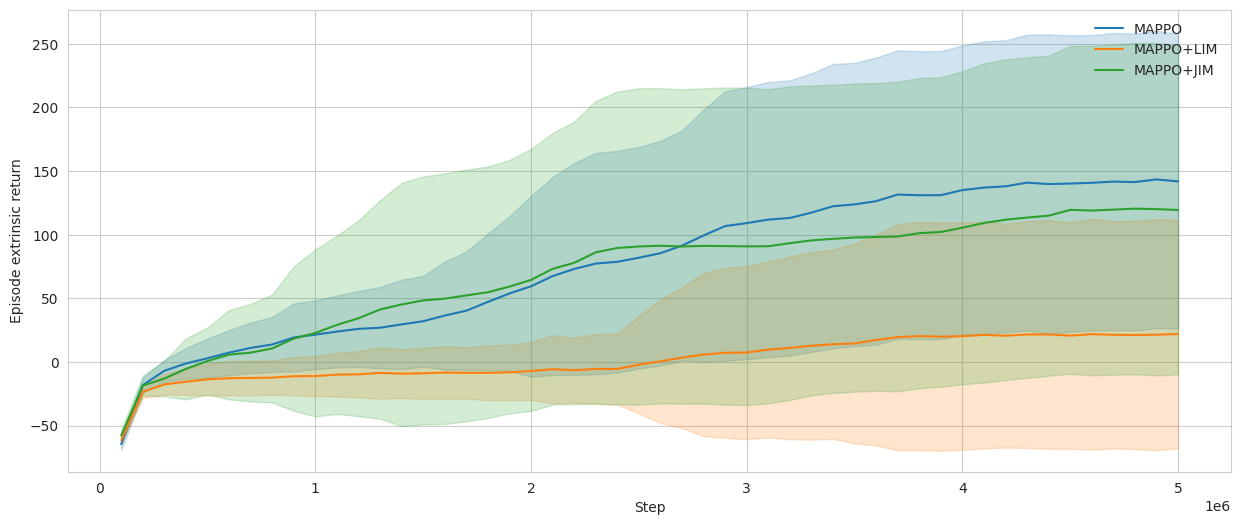

In [17]:
mappo_40 = load_data_files(
    "../models/rel_overgen/mappo_2a_4040/train_data/",
    name="MAPPO")
mappo_LIM_40 = load_data_files(
    "../models/rel_overgen/mappo_2a_4040_LIM/train_data/",
    name="MAPPO+LIM")
mappo_JIM_40 = load_data_files(
    "../models/rel_overgen/mappo_2a_4040_JIM/train_data/",
    name="MAPPO+JIM")
ro40 = [
    mov_avg(mappo_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_LIM_40, max_steps=5000000, step_range=100000, n_runs=15), 
    mov_avg(mappo_JIM_40, max_steps=5000000, step_range=100000, n_runs=15)]
plot_runs(ro40, y="Episode extrinsic return")

In [2]:
from matplotlib.lines import Line2D

def load_avg_n_plot_indivruns(
        path_list, x="Step", y="Episode extrinsic return", names=[],
        ax=None, ax_xlabel="Step", ax_ylabel="Episode extrinsic return",
        avg_range=10, figsize=(15, 6), max_steps=5000000, step_range=100000,
        linewidth=1.0, save_path=None, ylim=None):
    #Load runs
    models = []
    if type(path_list) is str:
        path_list = [path_list]
    for p in path_list:
        runs = []
        for file in os.listdir(p):
            run = pd.read_csv(os.path.join(p, file), index_col=0)
            #run = mov_avg_index(run, n_index=avg_range, diplay_prog=False)
            run = mov_avg(run, max_steps=max_steps, step_range=step_range, n_runs=1)
            runs.append(run)
        models.append(runs)
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    legends = []
    for m, n in zip(models, names):
        color = next(ax._get_lines.prop_cycler)['color']
        
        if "JIM" in n:
            color = next(ax._get_lines.prop_cycler)['color']
            line = "-"
        else:
            line = "--"
            
        if len(names) > 0:
            legends.append(Line2D([0], [0], color=color, lw=2, ls=line))
        for r in m:
            ax.plot(r[x], r[y], color=color, lw=linewidth, ls=line)
    
    ax.set(xlabel=ax_xlabel)
    ax.set(ylabel=ax_ylabel)
    
    if ylim is not None:
        ax.set(ylim=ylim)
    
    if len(names) > 0:
        ax.legend(legends, names, fontsize=8)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=500, bbox_inches='tight')
    
    plt.show()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


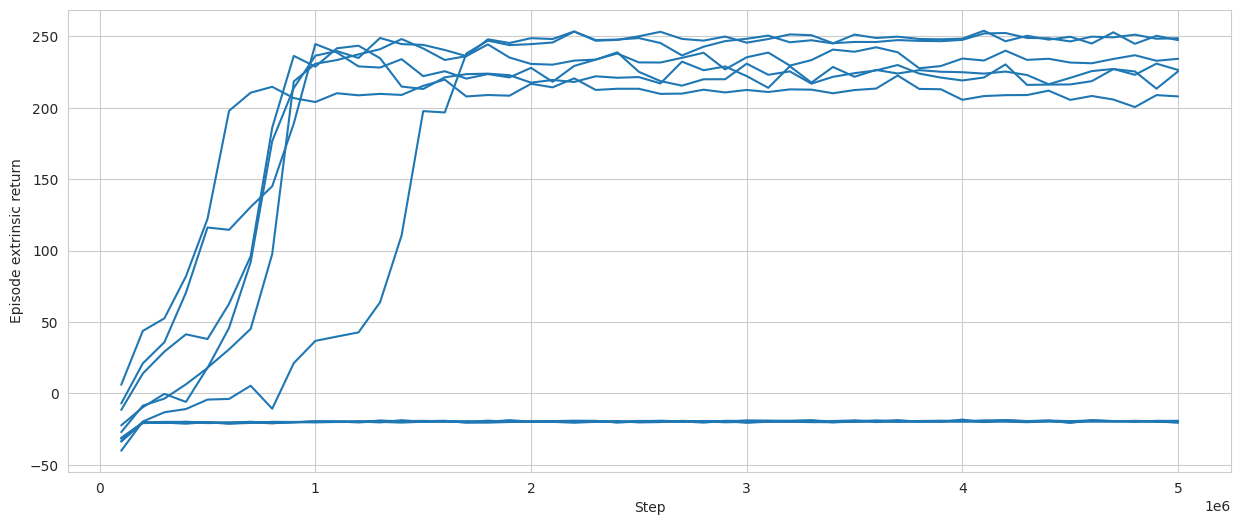

In [42]:

load_avg_n_plot_indivruns([
    "../models/rel_overgen/mappo_30/train_data/"], y="Episode return")

### 4 agents

100%|███████████████████████████████████████████| 11/11 [03:27<00:00, 18.82s/it]


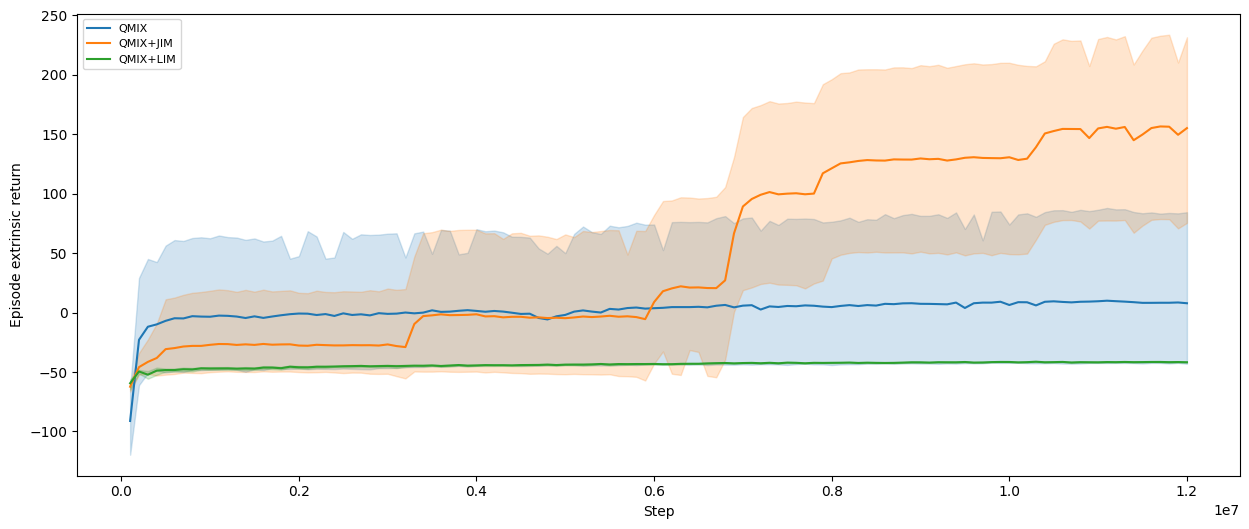

In [44]:
qmix = load_data_files(
    "../models/rel_overgen/qmix_4a_40_09/train_data/",
    name="QMIX")
qmix_jim = load_data_files(
    "../models/rel_overgen/qmix_4a_40_09_JIM/train_data/",
    name="QMIX+JIM")
qmix_lim = load_data_files(
    "../models/rel_overgen/qmix_4a_40_09_LIM/train_data/",
    name="QMIX+LIM")
qmix4a = [
    mov_avg(qmix, max_steps=12000000, step_range=100000, n_runs=11), 
    mov_avg(qmix_jim, max_steps=12000000, step_range=100000, n_runs=11), 
    mov_avg(qmix_lim, max_steps=12000000, step_range=100000, n_runs=11)]
plot_runs(qmix4a, y="Episode extrinsic return", err="ci")#, ax_ylabel="Episode extrinsic return") 
          #size=(3, 2.3), loc="upper left", estim="median", err="ci")
plt.legend(fontsize=8, loc="upper left")

In [45]:
qmix4a[1] = qmix4a[2]
qmix4a[2] = qmix4b[1]

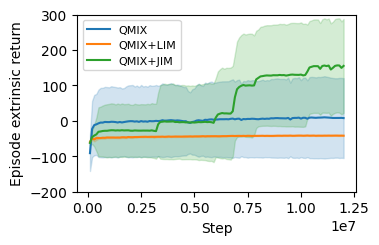

In [47]:

plot_runs(qmix4a, y="Episode extrinsic return", size=(3.6, 2.3), loc="upper left", ylim=[-200, 300])
plt.legend(fontsize=8, loc="upper left")
plt.savefig("figures/ro_4a.jpg", dpi=500, bbox_inches='tight')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


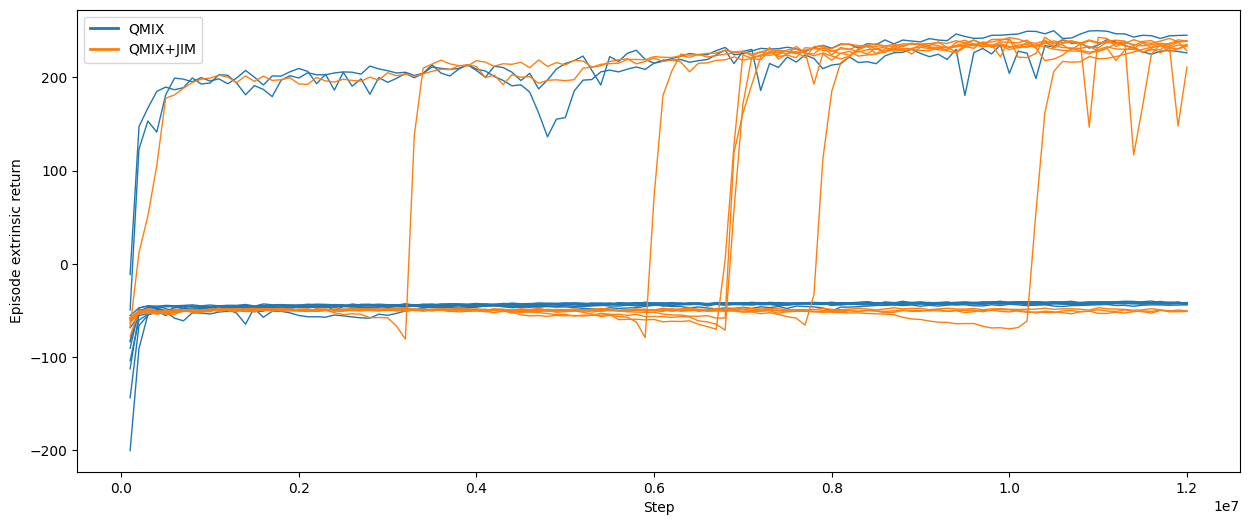

<Figure size 640x480 with 0 Axes>

In [30]:
load_avg_n_plot_indivruns([
    "../models/rel_overgen/qmix_4a_40_09/train_data/",
    "../models/rel_overgen/qmix_4a_40_09_JIM/train_data/"
], y="Episode extrinsic return", names=["QMIX", "QMIX+JIM"], max_steps=12000000, step_range=100000)

# Marche pas
# plt.savefig("figures/ro_4a_ALL.jpg", dpi=500, bbox_inches='tight')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


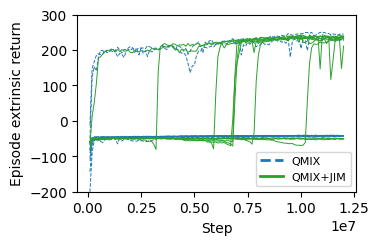

In [57]:
load_avg_n_plot_indivruns([
    "../models/rel_overgen/qmix_4a_40_09/train_data/",
    "../models/rel_overgen/qmix_4a_40_09_JIM/train_data/"
], y="Episode extrinsic return", names=["QMIX", "QMIX+JIM"], max_steps=12000000, step_range=100000, 
    figsize=(3.6, 2.3), linewidth=0.7, save_path="figures/ro_4a_ALL.jpg", ylim=[-200, 300])

# Marche pas
# plt.savefig("figures/ro_4a_ALL.jpg", dpi=500, bbox_inches='tight')

# Push buttons

Partially observable

Button size 1

Intrinsic reward weights:
- LIM 4
- JIM 2

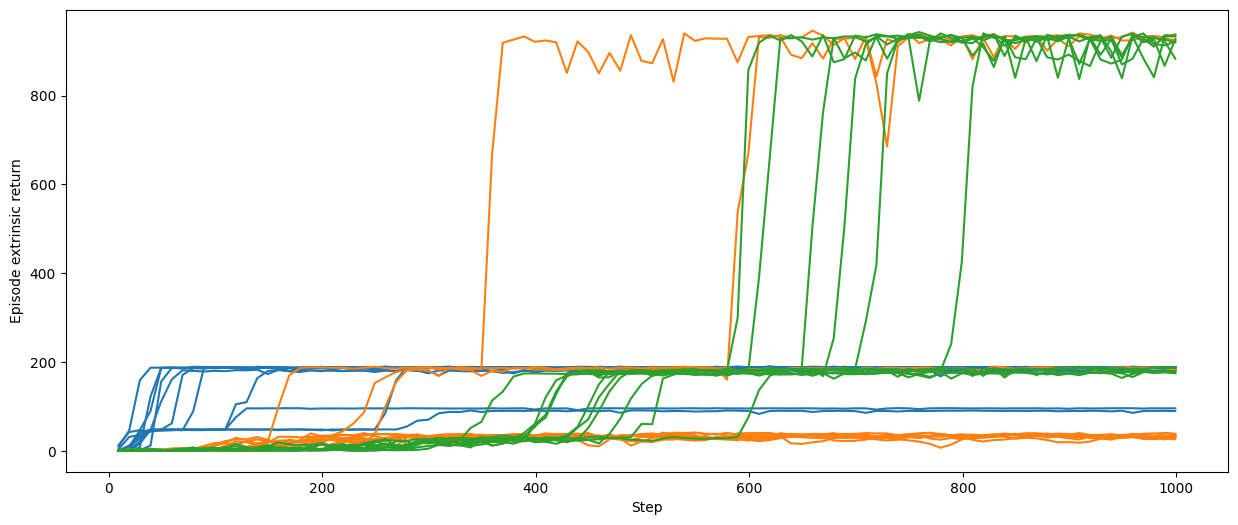

In [16]:

load_avg_n_plot_indivruns([
    "../models/push_buttons/qmix_pol/train_data_1/",
    "../models/push_buttons/qmix_lim_pol/train_data_1/",
    "../models/push_buttons/qmix_jim_pol/train_data_1/"
], y="Mean return")

100%|██████████████████████████████████████| 2200/2200 [00:03<00:00, 642.63it/s]


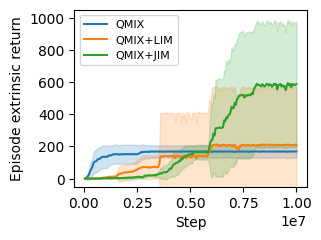

In [23]:
qmix = load_data_files(
    "../models/push_buttons/qmix_pol/train_data_1/",
    name="QMIX")
lim = load_data_files(
    "../models/push_buttons/qmix_lim_pol/train_data_1/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=5)
lim = mov_avg_index(lim, n_index=5)
jim = mov_avg_index(jim, n_index=5)

plot_runs([qmix, lim, jim], y="Mean return", ax_ylabel="Episode extrinsic return", 
          size=(3, 2.3), loc="upper left")
plt.ylim([-50, 1050])
plt.legend(fontsize=8, loc="upper left")
plt.savefig("figures/push_buttons_results.jpg", dpi=500, bbox_inches='tight')

100%|██████████████████████████████████████| 2200/2200 [00:04<00:00, 521.56it/s]
/tmp/ipykernel_4766/2032789009.py:101: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.lineplot(data=runs, x=x, y=y, hue="Name", ax=ax, estimator=estim, errorbar=err, palette=colors, ci=0)


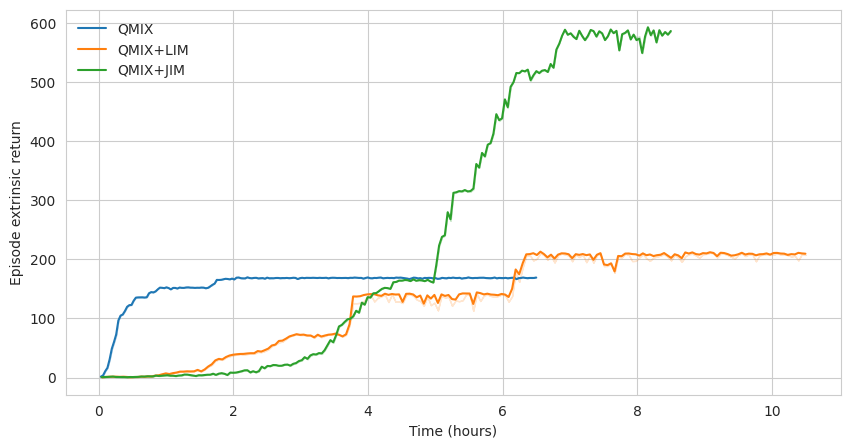

In [76]:
def add_time(data, max_time):
    max_step = data["Step"].max()
    data["Time (hours)"] = (data["Step"] / max_step) * max_time
    return data

qmix = load_data_files(
    "../models/push_buttons/qmix_pol/train_data_1/",
    name="QMIX")
lim = load_data_files(
    "../models/push_buttons/qmix_lim_pol/train_data_1/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=5)
lim = mov_avg_index(lim, n_index=5)
jim = mov_avg_index(jim, n_index=5)

add_time(qmix, 6.5)
add_time(lim, 10.5)
add_time(jim, 8.5)

sns.set_style("whitegrid")

plot_runs([qmix, lim, jim], x="Time (hours)", y="Mean return", 
          ax_ylabel="Episode extrinsic return", loc="upper left",
         size=(10, 5), err="ci")
plt.savefig("figures/push_button_time.jpg", dpi=500, bbox_inches='tight')

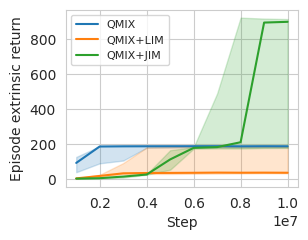

In [50]:
plot_runs([qmix, lim, jim], y="Mean return", ax_ylabel="Episode extrinsic return", 
          size=(3, 2.3), loc="upper left", estim="median", err="ci")
plt.legend(fontsize=8, loc="upper left")

100%|████████████████████████████████████████| 110/110 [00:00<00:00, 599.21it/s]


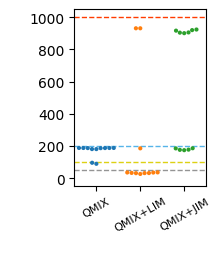

In [25]:
qmix = load_data_files(
    "../models/push_buttons/qmix_pol/train_data_1/",
    name="QMIX")
lim = load_data_files(
    "../models/push_buttons/qmix_lim_pol/train_data_1/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=100)
lim = mov_avg_index(lim, n_index=100)
jim = mov_avg_index(jim, n_index=100)

ax = box_plot_runs([qmix, lim, jim], y="Mean return", ax_ylabel=" ", ax_xlabel=" ",
              only_one_step=10000000, size=(1.7, 2.3), legend=False, swarm=True)
plt.xticks(fontsize=8)

#sns.set_style("white")
ax.axhline(y=1000, color='#ff3c00', linestyle='--', linewidth=1)
ax.axhline(y=200, color='#56b4e9', linestyle='--', linewidth=1)
ax.axhline(y=100, color='#ddd114', linestyle='--', linewidth=1)
ax.axhline(y=50, color='#949494', linestyle='--', linewidth=1)
plt.ylim([-50, 1050])
plt.savefig("figures/push_buttons_results_last_lines.jpg", dpi=500, bbox_inches='tight')

# Ablations

100%|██████████████████████████████████████| 2200/2200 [00:04<00:00, 463.36it/s]


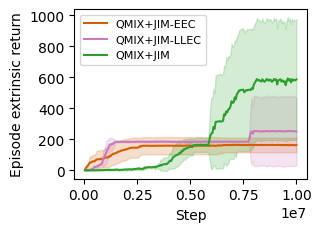

In [129]:
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
eec = load_data_files(
    "../models/push_buttons/qmix_jim-eec_pol/train_data/",
    name="QMIX+JIM-EEC")
llec = load_data_files(
    "../models/push_buttons/qmix_jim-llec_pol/train_data/",
    name="QMIX+JIM-LLEC")
jim = mov_avg_index(jim, n_index=5)
eec = mov_avg_index(eec, n_index=5)
llec = mov_avg_index(llec, n_index=5)

plot_runs([eec, llec, jim], y="Mean return", ax_ylabel="Episode extrinsic return", 
          size=(3, 2.2), loc="upper left", 
          colors={"QMIX+JIM": "#2CA02C", "QMIX+JIM-EEC": "#D55E00", "QMIX+JIM-LLEC": "#CC78BC"})
plt.legend(fontsize=8, loc="upper left")
plt.savefig("ablation.jpg", dpi=500, bbox_inches='tight')

100%|██████████████████████████████████████| 2200/2200 [00:05<00:00, 405.62it/s]


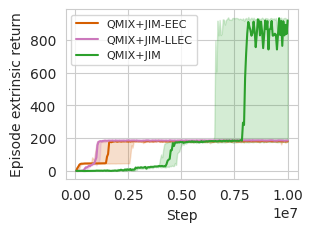

In [19]:
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
eec = load_data_files(
    "../models/push_buttons/qmix_jim-eec_pol/train_data/",
    name="QMIX+JIM-EEC")
llec = load_data_files(
    "../models/push_buttons/qmix_jim-llec_pol/train_data/",
    name="QMIX+JIM-LLEC")
jim = mov_avg_index(jim, n_index=5)
eec = mov_avg_index(eec, n_index=5)
llec = mov_avg_index(llec, n_index=5)

plot_runs([eec, llec, jim], y="Mean return", ax_ylabel="Episode extrinsic return", 
          size=(3, 2.2), loc="upper left", estim="median", err="ci",
          colors={"QMIX+JIM": "#2CA02C", "QMIX+JIM-EEC": "#D55E00", "QMIX+JIM-LLEC": "#CC78BC"})
plt.legend(fontsize=8, loc="upper left")

100%|████████████████████████████████████████| 110/110 [00:00<00:00, 408.46it/s]
/home/doctoq/Desktop/Dev/MADRL-Cooperative-Push-Env/venv/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/doctoq/Desktop/Dev/MADRL-Cooperative-Push-Env/venv/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


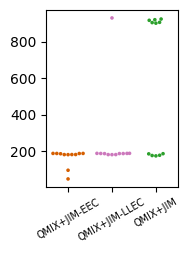

In [132]:
jim = load_data_files(
    "../models/push_buttons/qmix_jim_pol/train_data_1/",
    name="QMIX+JIM")
eec = load_data_files(
    "../models/push_buttons/qmix_jim-eec_pol/train_data/",
    name="QMIX+JIM-EEC")
llec = load_data_files(
    "../models/push_buttons/qmix_jim-llec_pol/train_data/",
    name="QMIX+JIM-LLEC")
jim = mov_avg_index(jim, n_index=100)
eec = mov_avg_index(eec, n_index=100)
llec = mov_avg_index(llec, n_index=100)

box_plot_runs([eec, llec, jim], y="Mean return", ax_ylabel="", ax_xlabel="",
              only_one_step=10000000, size=(1.7, 2.3), legend=False, swarm=True, swarm_size=2.6,
             colors={"QMIX+JIM": "#2CA02C", "QMIX+JIM-EEC": "#D55E00", "QMIX+JIM-LLEC": "#CC78BC"})
plt.xticks(fontsize=7)
plt.savefig("ablation_last.jpg", dpi=500, bbox_inches='tight')

# Coop push

In [28]:
def mod(run):
    run["Episode return"] -= 0.9 * run["Episode length"]
    run["Episode extrinsic return"] -= 0.9 * run["Episode length"]

def load_and_mod(path, name=None, mod_fn=None, mod_runs=[]):
    runs = ["run" + str(r) + ".csv" for r in mod_runs]
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            if file in runs:
                #run["Episode return"] -= 90
                #run["Episode extrinsic return"] -= 90
                mod_fn(run)
            if data is None:
                data = run
            else:
                data = data.append(run, ignore_index=True)
    if name is not None:
        data["Name"] = name
    return data

100%|████████████████████████████████████████| 550/550 [00:00<00:00, 554.08it/s]


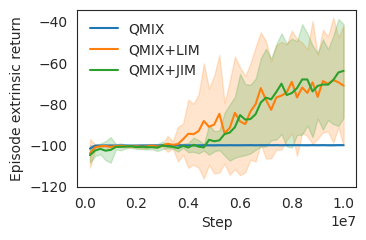

In [68]:
qmix = load_and_mod(
    "../models/coop_push_corners/qmix/train_data/",
    name="QMIX", mod_fn=mod, mod_runs=[1,2,3,4,5,6,7])
lim = load_and_mod(
    "../models/coop_push_corners/qmix_lim/train_data/",
    name="QMIX+LIM")
jim = load_and_mod(
    "../models/coop_push_corners/qmix_jim/train_data/",
    name="QMIX+JIM")
qmix = mov_avg(qmix, max_steps=10000000, step_range=200000, n_runs=11)
lim = mov_avg_index(lim, n_index=20)
lim = lim.rename(columns={"Mean return": "Episode extrinsic return"})
jim = mov_avg_index(jim, n_index=20)
jim = jim.rename(columns={"Mean return": "Episode extrinsic return"})

plot_runs([qmix, lim, jim], y="Episode extrinsic return", 
          size=(3.6, 2.3), loc="upper left")
plt.savefig("figures/coop_push_results.jpg", dpi=500, bbox_inches='tight')

100%|████████████████████████████████████████| 550/550 [00:01<00:00, 548.95it/s]


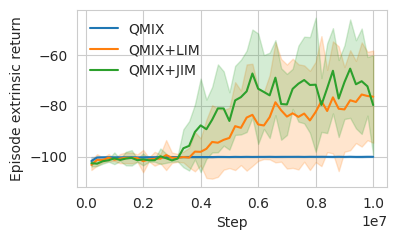

In [79]:
qmix = load_and_mod(
    "../models/coop_push_corners/qmix/train_data/",
    name="QMIX", mod_fn=mod, mod_runs=[1,2,3,4,5,6,7])
lim = load_and_mod(
    "../models/coop_push_corners_new/qmix_lim_pol/train_data/",
    name="QMIX+LIM")
jim = load_and_mod(
    "../models/coop_push_corners_new/qmix_jim_pol/train_data/",
    name="QMIX+JIM")
qmix = mov_avg(qmix, max_steps=10000000, step_range=200000, n_runs=11)
lim = mov_avg_index(lim, n_index=20)
lim = lim.rename(columns={"Mean return": "Episode extrinsic return"})
jim = mov_avg_index(jim, n_index=20)
jim = jim.rename(columns={"Mean return": "Episode extrinsic return"})

plot_runs([qmix, lim, jim], y="Episode extrinsic return", 
          size=(4, 2.3), loc="upper left")

100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.54it/s]


([0, 1, 2],
 [Text(0, 0, 'QMIX'), Text(1, 0, 'QMIX+LIM'), Text(2, 0, 'QMIX+JIM')])

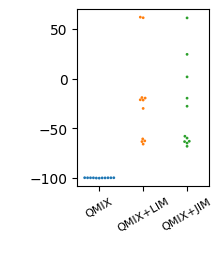

In [113]:
qmix = load_and_mod(
    "../models/coop_push_corners/qmix/train_data/",
    name="QMIX", mod_fn=mod, mod_runs=[1,2,3,4,5,6,7])
lim = load_and_mod(
    "../models/coop_push_corners/qmix_loc_e2snoveld_invdyn/train_data/",
    name="QMIX+LIM", mod_fn=mod, mod_runs=[1,2,3,4,5,6,7])
jim = load_and_mod(
    "../models/coop_push_corners/qmix_cent_e2snoveld_inv_dyn/train_data/",
    name="QMIX+JIM", mod_fn=mod, mod_runs=[1,2,3,4,5])
qmix = mov_avg(qmix, max_steps=10000000, step_range=1000000, n_runs=11)
lim = mov_avg(lim, max_steps=10000000, step_range=1000000, n_runs=11)
jim = mov_avg(jim, max_steps=10000000, step_range=1000000, n_runs=11)

ax = box_plot_runs([qmix, lim, jim], y="Episode extrinsic return", ax_ylabel=" ", ax_xlabel=" ",
              only_one_step=10000000, size=(1.7, 2.3), legend=False, swarm=True, swarm_size=2)
plt.xticks(fontsize=8)

100%|████████████████████████████████████████| 825/825 [00:01<00:00, 445.48it/s]


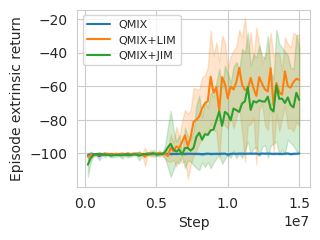

In [30]:
qmix = load_data_files(
    "../models/coop_push_corners/qmix_15/train_data/",
    name="QMIX")
lim = load_data_files(
    "../models/coop_push_corners/qmix_lim_15/train_data/",
    name="QMIX+LIM")
jim = load_data_files(
    "../models/coop_push_corners/qmix_jim_15/train_data/",
    name="QMIX+JIM")
qmix = mov_avg_index(qmix, n_index=20)
lim = mov_avg_index(lim, n_index=20)
jim = mov_avg_index(jim, n_index=20)

plot_runs([qmix, lim, jim], y="Mean return", ax_ylabel="Episode extrinsic return", 
          size=(3, 2.3), loc="upper left")
plt.legend(fontsize=8, loc="upper left")

# Trajectories

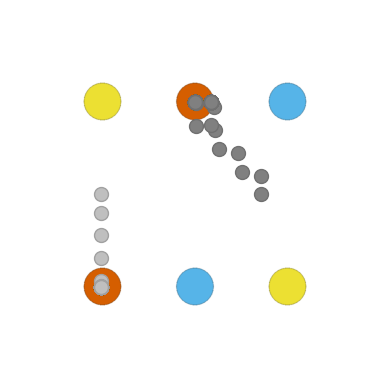

In [197]:
import json

im = plt.imread("push_buttons_noagent.png")
plt.imshow(im)

with open("traj.json", 'r') as f:
    traj = json.load(f)
traj = np.array(traj[0])
traj[:,:,1] *= -1
traj = (traj + 1) * 350

plt.scatter(traj[:,0,0].flatten(), traj[:,0,1].flatten(), c="#BFBFBF", edgecolors="#A1A1A1", s=100)
plt.scatter(traj[:,1,0].flatten(), traj[:,1,1].flatten(), c="#808080", edgecolors="#707070", s=100)
plt.axis('off')

plt.savefig("figures/push_buttons_traj_top_jim1.jpg", dpi=500, bbox_inches='tight')